# CNNs Intro

## 1) 1D CNNs

In [90]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

import cv2

import random
import matplotlib.pyplot as plt

##### Самописная 1D конволюция
##### Пройдемся фильтром длины 3 по одномерному массиву:

In [2]:
image_len = 6
image = [i for i in range(image_len)]
image

[0, 1, 2, 3, 4, 5]

In [3]:
filter_1d = [-1, 0, 2]
filter_1d

[-1, 0, 2]

In [4]:
image_filtered = []
for i in range(image_len-2):
    val = 0
    for j in range(3):
        pass
        ### YOUR CODE HERE
        val += image[i+j] * filter_1d[j]
        
    image_filtered.append(val)
image_filtered

[4, 5, 6, 7]

##### То же самое на PyTorch

In [19]:
image_tensor = torch.arange(6).float()
image_tensor

tensor([0., 1., 2., 3., 4., 5.])

In [20]:
# объявляем конволюцию
conv1d_1 = nn.Conv1d(in_channels=1, out_channels=1, kernel_size=3, stride=1, padding=0, bias=False)
conv1d_1

Conv1d(1, 1, kernel_size=(3,), stride=(1,), bias=False)

In [21]:
# так работать не будет, см. след. ячейку
conv1d_1(image_tensor)

RuntimeError: Expected 3-dimensional input for 3-dimensional weight [1, 1, 3], but got 1-dimensional input of size [6] instead

In [22]:
"""
Модуль ожидает, что на вход придет батч картинок. 
Поэтому первое измерение входного тензора - размер батча (в нашем случае = 1).
Второе измерение - количество каналов (например, в картинках часто бывает 3 канала - RGB).  
В нашем случае, количество каналов = 1
""" 
conv1d_1(image_tensor.unsqueeze(0).unsqueeze(0))

tensor([[[-0.2667, -0.9517, -1.6366, -2.3216]]], grad_fn=<SqueezeBackward1>)

In [23]:
conv1d_1.weight# Мы получили не те значения, что и в прошлом упражнении. Попробуем разобраться и посмотрим на наш фильтр:
conv1d_1.weight, conv1d_1.weight.shape

(Parameter containing:
 tensor([[[-0.4238, -0.2558, -0.0054]]], requires_grad=True),
 torch.Size([1, 1, 3]))

In [24]:
# Давайте заменим этот фильтр на фильтр из прошлого упражнения:
conv1d_1.weight = nn.Parameter(torch.Tensor([-1, 0, 2]).unsqueeze(0).unsqueeze(0))
conv1d_1.weight

Parameter containing:
tensor([[[-1.,  0.,  2.]]], requires_grad=True)

In [25]:
# Мы получили те же значения, что и в прошлом упражнении:
conv1d_1(image_tensor.unsqueeze(0).unsqueeze(0))

tensor([[[4., 5., 6., 7.]]], grad_fn=<SqueezeBackward1>)

In [26]:
# Обратите внимание, что размер выходного вектора - 4, а у исходного был 6.
# Чтобы размер сохранялся, нужно использовать padding: 
#    исходный вектор будет расширяться с двух сторон на заданную длину
#    Укажите в объявлении конволюции параметр padding=1
conv1d_2 = nn.Conv1d(in_channels=1, out_channels=1, kernel_size=3, stride=1, padding=1, bias=False)
conv1d_2.weight.data = conv1d_1.weight.data

In [31]:
# длина выходного вектора теперь тоже равна 6
conv1d_2(image_tensor.unsqueeze(0).unsqueeze(0))

tensor([[[ 2.,  4.,  6.,  8., 10.,  0.]]], grad_fn=<SqueezeBackward1>)

## 2) 2D CNNs

In [32]:
image_tensor_2d = torch.arange(9).reshape(3,3).float()
print(image_tensor_2d.shape)
print(image_tensor_2d)

torch.Size([3, 3])
tensor([[0., 1., 2.],
        [3., 4., 5.],
        [6., 7., 8.]])


In [33]:
filter_2d = torch.arange(4).reshape(2,2).float().unsqueeze(0).unsqueeze(0)
print(filter_2d.shape)
print(filter_2d)

torch.Size([1, 1, 2, 2])
tensor([[[[0., 1.],
          [2., 3.]]]])


In [34]:
### Объявляем 2D-конволюцию
conv2d_1 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=2, stride=1, padding=0, bias=False)
conv2d_1.weight

Parameter containing:
tensor([[[[ 0.1825, -0.3867],
          [-0.0208, -0.3883]]]], requires_grad=True)

In [35]:
conv2d_1.weight = nn.Parameter(filter_2d)
conv2d_1.weight

Parameter containing:
tensor([[[[0., 1.],
          [2., 3.]]]], requires_grad=True)

In [36]:
conv2d_1(image_tensor_2d.unsqueeze(0).unsqueeze(0))

tensor([[[[19., 25.],
          [37., 43.]]]], grad_fn=<MkldnnConvolutionBackward>)

In [37]:
# Добавляем padding
conv2d_2 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=2, stride=1, padding=1, bias=False)
conv2d_2.weight = conv2d_1.weight
conv2d_2(image_tensor_2d.unsqueeze(0).unsqueeze(0))

tensor([[[[ 0.,  3.,  8.,  4.],
          [ 9., 19., 25., 10.],
          [21., 37., 43., 16.],
          [ 6.,  7.,  8.,  0.]]]], grad_fn=<MkldnnConvolutionBackward>)

In [38]:
# Играемся с параметром padding
conv2d_3 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=2, stride=1, padding=(1, 0), bias=False)
conv2d_3.weight = conv2d_1.weight
conv2d_3(image_tensor_2d.unsqueeze(0).unsqueeze(0))

tensor([[[[ 3.,  8.],
          [19., 25.],
          [37., 43.],
          [ 7.,  8.]]]], grad_fn=<MkldnnConvolutionBackward>)

In [39]:
# Играемся с параметром padding
conv2d_4 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=2, stride=1, padding=(0, 1), bias=False)
conv2d_4.weight = conv2d_1.weight
conv2d_4(image_tensor_2d.unsqueeze(0).unsqueeze(0))

tensor([[[[ 9., 19., 25., 10.],
          [21., 37., 43., 16.]]]], grad_fn=<MkldnnConvolutionBackward>)

In [40]:
# Можно сначала падить через функцию, а затем подавать тензор в конволюционный слой
F.pad(image_tensor_2d.unsqueeze(0).unsqueeze(0), (1,1,0,0), mode='constant')

tensor([[[[0., 0., 1., 2., 0.],
          [0., 3., 4., 5., 0.],
          [0., 6., 7., 8., 0.]]]])

In [41]:
# Этот способ более гибкий, потому что позволяет падить только с одной выбранной стороны:
F.pad(image_tensor_2d.unsqueeze(0).unsqueeze(0), (1,0,0,0), mode='constant')

tensor([[[[0., 0., 1., 2.],
          [0., 3., 4., 5.],
          [0., 6., 7., 8.]]]])

In [42]:
# 
# Вспомним выход нашей первой 2D конволюции
conv2d_1(image_tensor_2d.unsqueeze(0).unsqueeze(0))

tensor([[[[19., 25.],
          [37., 43.]]]], grad_fn=<MkldnnConvolutionBackward>)

In [43]:
### За что же отвечает параметр bias?
conv2d_5 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=2, stride=1, padding=0, bias=True)
conv2d_5.weight = conv2d_1.weight
conv2d_5.bias

Parameter containing:
tensor([-0.0653], requires_grad=True)

In [44]:
# сделаем bias равным единице:
conv2d_5.bias = nn.Parameter(torch.ones(1))
conv2d_5.bias

Parameter containing:
tensor([1.], requires_grad=True)

In [45]:
# вспомним выход из нашей первой конволюции, и сравним его с выходом с учетом bias:
print(conv2d_1(image_tensor_2d.unsqueeze(0).unsqueeze(0)))
print(conv2d_5(image_tensor_2d.unsqueeze(0).unsqueeze(0)))

tensor([[[[19., 25.],
          [37., 43.]]]], grad_fn=<MkldnnConvolutionBackward>)
tensor([[[[20., 26.],
          [38., 44.]]]], grad_fn=<MkldnnConvolutionBackward>)


In [46]:
# Кстати, наш фильтр не обязательно будет квадратным:
conv2d_6 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(1,3), stride=1, padding=0, bias=False)
conv2d_6.weight.shape

torch.Size([1, 1, 1, 3])

In [47]:
conv2d_6.weight = nn.Parameter(torch.arange(3).float().reshape(1,1,1,3))
conv2d_6.weight

Parameter containing:
tensor([[[[0., 1., 2.]]]], requires_grad=True)

In [48]:
# Пробегаться по картинке можно и фильтром 1x1:
conv2d_7 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=1, stride=1, padding=0, bias=False)
conv2d_7.weight = nn.Parameter(torch.ones(1, 1, 1, 1)*2)
conv2d_7.weight

Parameter containing:
tensor([[[[2.]]]], requires_grad=True)

In [49]:
conv2d_7(image_tensor_2d.unsqueeze(0).unsqueeze(0))

tensor([[[[ 0.,  2.,  4.],
          [ 6.,  8., 10.],
          [12., 14., 16.]]]], grad_fn=<MkldnnConvolutionBackward>)

In [50]:
# А сейчас посмотрим на stride в действии:
conv2d_8 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=1, stride=2, padding=0, bias=False)
conv2d_8.weight = nn.Parameter(torch.ones(1, 1, 1, 1)*2)
conv2d_8.weight

Parameter containing:
tensor([[[[2.]]]], requires_grad=True)

In [51]:
conv2d_8(image_tensor_2d.unsqueeze(0).unsqueeze(0))

tensor([[[[ 0.,  4.],
          [12., 16.]]]], grad_fn=<MkldnnConvolutionBackward>)

In [52]:
# Как и с остальными параметрами, stride может быть разным по разным осям:
conv2d_9 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=1, stride=(2, 1), padding=0, bias=False)
conv2d_9.weight = nn.Parameter(torch.ones(1, 1, 1, 1)*2)
conv2d_9(image_tensor_2d.unsqueeze(0).unsqueeze(0))

tensor([[[[ 0.,  2.,  4.],
          [12., 14., 16.]]]], grad_fn=<MkldnnConvolutionBackward>)

## 3) Let's work with pictures

In [93]:
path = './lecun.jpeg'

In [94]:
# Прочитайте изображение в grayscale и rgb (cv2.imread, флаг 0 - grayscale)
img_grayscale = cv2.imread(path, 0) # 0 означет grayscale
img_rgb = cv2.imread(path)

In [95]:
assert img_grayscale.shape == (3960, 2640)
assert img_rgb.shape == (3960, 2640, 3)

In [97]:
def show_image(image, cmap=None, figsize=(16, 9)):
    plt.figure(figsize=figsize)
    plt.imshow(image, cmap=cmap)
    plt.axis('off')
    plt.show()

In [1]:
#uncomment to see the grayscale image
# show_image(img_grayscale, cmap="gray")

In [3]:
# uncomment to see the change in the picture
# синий и красный каналы перепутаны в cv2
#show_image(img_rgb[:, :, ::-1])

In [100]:
# функция, которая переводит изображение в тензор
to_tensor = torchvision.transforms.ToTensor()

In [101]:
tensor_grayscale = to_tensor(img_grayscale)
tensor_rgb = to_tensor(img_rgb)

In [102]:
# pytorch хранит канал в нулевой размерности
print(tensor_grayscale.shape)
print(tensor_rgb.shape)

torch.Size([1, 3960, 2640])
torch.Size([3, 3960, 2640])


In [103]:
tensor_grayscale = tensor_grayscale.reshape([1, 1, 3960, 2640])
tensor_rgb = tensor_rgb.unsqueeze(0)

In [104]:
assert tensor_grayscale.shape == torch.Size([1, 1, 3960, 2640])
assert tensor_rgb.shape == torch.Size([1, 3, 3960, 2640])

### Создадим свертку, которая размоет чёрно-белое изображение

In [106]:
kernel_size = 50
layer_grayscale = nn.Conv2d(1, 1, kernel_size=kernel_size, bias=False)

In [110]:
#Your code here
layer_grayscale.weight.data = torch.ones_like(layer_grayscale.weight.data)
layer_grayscale.weight.data /= torch.sum(layer_grayscale.weight.data)

In [111]:
layer_grayscale.weight.data

tensor([[[[0.0004, 0.0004, 0.0004,  ..., 0.0004, 0.0004, 0.0004],
          [0.0004, 0.0004, 0.0004,  ..., 0.0004, 0.0004, 0.0004],
          [0.0004, 0.0004, 0.0004,  ..., 0.0004, 0.0004, 0.0004],
          ...,
          [0.0004, 0.0004, 0.0004,  ..., 0.0004, 0.0004, 0.0004],
          [0.0004, 0.0004, 0.0004,  ..., 0.0004, 0.0004, 0.0004],
          [0.0004, 0.0004, 0.0004,  ..., 0.0004, 0.0004, 0.0004]]]])

In [113]:
layer_grayscale.eval()

Conv2d(1, 1, kernel_size=(50, 50), stride=(1, 1), bias=False)

In [114]:
output_tensor_grayscale = layer_grayscale(tensor_grayscale)

In [115]:
output_tensor_grayscale.shape

torch.Size([1, 1, 3911, 2591])

In [116]:
# функция, переводящая тензор в PIL-изображение
to_pil_image = torchvision.transforms.ToPILImage()

In [117]:
print("Исходный размер изображения:", output_tensor_grayscale.shape)
print("Сжатие всех измерений:", output_tensor_grayscale.squeeze().shape)
print("Сжатие измерения 0:", output_tensor_grayscale.squeeze(0).shape)
print("Сжатие измерения 1:", output_tensor_grayscale.squeeze(1).shape)
print("Сжатие измерения 2:", output_tensor_grayscale.squeeze(2).shape)
print("Сжатие измерения 3:", output_tensor_grayscale.squeeze(3).shape)

Исходный размер изображения: torch.Size([1, 1, 3911, 2591])
Сжатие всех измерений: torch.Size([3911, 2591])
Сжатие измерения 0: torch.Size([1, 3911, 2591])
Сжатие измерения 1: torch.Size([1, 3911, 2591])
Сжатие измерения 2: torch.Size([1, 1, 3911, 2591])
Сжатие измерения 3: torch.Size([1, 1, 3911, 2591])


In [118]:
output_img_grayscale = output_tensor_grayscale.squeeze(0)

In [4]:
#blurred image (uncomment and run to see)
# to_pil_image(output_img_grayscale)

### Создадим свертку, которая размоет цветное изображение

In [120]:
kernel_size = 50
layer_rgb = nn.Conv2d(3, 3, kernel_size=kernel_size)

In [121]:
# (out_channels, in_channels, size, size)
layer_rgb.weight.data.shape

torch.Size([3, 3, 50, 50])

In [122]:
layer_rgb.weight.data = torch.zeros_like(layer_rgb.weight.data)

for i in range(3):
    layer_rgb.weight.data[i][i] = torch.ones_like(layer_rgb.weight.data[i][i])
    layer_rgb.weight.data[i][i] /= torch.sum(layer_rgb.weight.data[i][i])

layer_rgb.bias.data = torch.zeros_like(layer_rgb.bias.data)

In [123]:
layer_rgb.bias.data

tensor([0., 0., 0.])

In [124]:
layer_rgb.eval()

Conv2d(3, 3, kernel_size=(50, 50), stride=(1, 1))

In [125]:
output_tensor_rgb = layer_rgb(tensor_rgb)

In [126]:
output_tensor_rgb.shape

torch.Size([1, 3, 3911, 2591])

In [127]:
output_img_rgb = output_tensor_rgb.squeeze(0)

In [5]:
#uncomment to see
#to_pil_image(output_img_rgb)

In [129]:
# синий и красный каналы перепутаны
channel_0 = output_img_rgb[0:1, :, :].clone()
channel_2 = output_img_rgb[2:3, :, :].clone()

output_img_rgb[0:1, :, :] = channel_2
output_img_rgb[2:3, :, :] = channel_0

In [6]:
# uncomment to see
# to_pil_image(output_img_rgb)

### Посмотрим на границы

In [131]:
kernel_size = 3
layer_vertical_border = nn.Conv2d(1, 1, kernel_size=kernel_size)
layer_horizontal_border = nn.Conv2d(1, 1, kernel_size=kernel_size)
layer_full_border = nn.Conv2d(1, 1, kernel_size=kernel_size)

In [132]:
print(layer_vertical_border.weight.data.shape)
print(layer_horizontal_border.weight.data.shape)
print(layer_full_border.weight.data.shape)

torch.Size([1, 1, 3, 3])
torch.Size([1, 1, 3, 3])
torch.Size([1, 1, 3, 3])


In [133]:
conv_vertical_border = torch.tensor([-1, 0, 1, -2, 0, 2, -1, 0, 1]).reshape([3, 3])
conv_vertical_border

tensor([[-1,  0,  1],
        [-2,  0,  2],
        [-1,  0,  1]])

In [134]:
conv_horizontal_border = torch.tensor([-1, -2, -1, 0, 0, 0, 1, 2, 1]).reshape([3, 3])
conv_horizontal_border

tensor([[-1, -2, -1],
        [ 0,  0,  0],
        [ 1,  2,  1]])

In [135]:
conv_full_border = torch.tensor([-1, -1, -1, -1, 8, -1, -1, -1, -1]).reshape([3, 3])
conv_full_border

tensor([[-1, -1, -1],
        [-1,  8, -1],
        [-1, -1, -1]])

In [136]:
layer_vertical_border.weight.data[0][0] = conv_vertical_border
layer_horizontal_border.weight.data[0][0] = conv_horizontal_border
layer_full_border.weight.data[0][0] = conv_full_border

layer_vertical_border.bias.data = torch.zeros_like(layer_vertical_border.bias.data)
layer_horizontal_border.bias.data = torch.zeros_like(layer_horizontal_border.bias.data)
layer_full_border.bias.data = torch.zeros_like(layer_full_border.bias.data)

In [139]:
print(torch.sum(layer_vertical_border.weight.data))
print(torch.sum(layer_horizontal_border.weight.data))
print(torch.sum(layer_full_border.weight.data))

tensor(0.)
tensor(0.)
tensor(0.)


In [143]:
print(layer_vertical_border.weight.data)
print()
print(layer_horizontal_border.weight.data)
print()
print(layer_full_border.weight.data)

tensor([[[[-1.,  0.,  1.],
          [-2.,  0.,  2.],
          [-1.,  0.,  1.]]]])

tensor([[[[-1., -2., -1.],
          [ 0.,  0.,  0.],
          [ 1.,  2.,  1.]]]])

tensor([[[[-1., -1., -1.],
          [-1.,  8., -1.],
          [-1., -1., -1.]]]])


In [144]:
layer_vertical_border.eval()
layer_horizontal_border.eval()
layer_full_border.eval()

Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1))

In [145]:
output_tensor_vertical_border = layer_vertical_border(tensor_grayscale)
output_tensor_horizontal_border = layer_horizontal_border(tensor_grayscale)
output_tensor_full_border = layer_full_border(tensor_grayscale)

In [146]:
print(output_tensor_vertical_border.shape)
print(output_tensor_horizontal_border.shape)
print(output_tensor_full_border.shape)

torch.Size([1, 1, 3958, 2638])
torch.Size([1, 1, 3958, 2638])
torch.Size([1, 1, 3958, 2638])


In [147]:
output_img_vertical_border = output_tensor_vertical_border.squeeze(0)
output_img_horizontal_border = output_tensor_horizontal_border.squeeze(0)
output_img_full_border = output_tensor_full_border.squeeze(0)

output_img_vertical_border[output_img_vertical_border < 0] = 0
output_img_vertical_border[output_img_vertical_border > 1] = 1

output_img_horizontal_border[output_img_horizontal_border < 0] = 0
output_img_horizontal_border[output_img_horizontal_border > 1] = 1

output_img_full_border[output_img_full_border < 0] = 0
output_img_full_border[output_img_full_border > 1] = 1

In [7]:
#uncomment to see
# to_pil_image(img_grayscale)

In [8]:
#uncomment to see
# to_pil_image(output_img_vertical_border)

In [9]:
#uncomment to see
# to_pil_image(output_img_horizontal_border)

In [10]:
#uncomment to see
# to_pil_image(output_img_full_border)

## 4) MNIST  Classification

In [53]:
# MNIST - подкласс torch.utils.data.Dataset, и поддерживает __getitem__(), 
#     т.е. можно получать элементы по индексу, как в листе:
train_dataset = torchvision.datasets.MNIST(root='.', download=True)
print(train_dataset[0])
train_dataset[0][0]

(<PIL.Image.Image image mode=L size=28x28 at 0x7F2C2C2946A0>, 5)


In [54]:
# Чтобы датасет возвращал тензоры, а не  PIL.Image объекты, добавим трансформации
# Нормализуем данные для более легкого обучения модели (mean, std посчитаны)
transform=transforms.Compose([
   transforms.ToTensor(),
   transforms.Normalize((0.1307,), (0.3081,))
])
train_dataset = torchvision.datasets.MNIST(root='.', transform=transform, download=True)
test_dataset  = torchvision.datasets.MNIST(root='.', transform=transform, train=False, download=True)
train_dataset[0]

(tensor([[[-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.424

In [55]:
len(train_dataset), len(test_dataset)

(60000, 10000)

Digit: 4


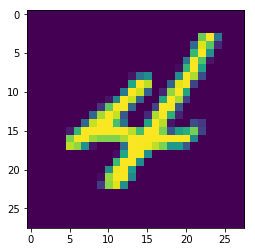

In [56]:
ind = random.randint(0, len(train_dataset)-1)
plt.imshow(train_dataset[ind][0].squeeze(0))
print('Digit:', train_dataset[ind][1])

In [57]:
# Данные из датасета в модель будет отправлять Dataloader.
# Он отвечает за сэмплирование данных, чтение (в т.ч. параллельное) с диска и собирание данных в батчи
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True, num_workers=4)

In [59]:
### YOUR CODE HERE
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=5, kernel_size=3, stride=2, padding=0, bias=True)
        self.conv2 = nn.Conv2d(in_channels=5, out_channels=10, kernel_size=3, stride=2, padding=0, bias=True)
        self.linear1 = nn.Linear(360, 10)
    
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = x.reshape(-1, 360)
        x = self.linear1(x)
        return x

In [60]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = CNNModel().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

num_epochs = 4
for epoch in range(num_epochs):
    model.train()
    for batch_idx, (data, target) in enumerate(train_dataloader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 200 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_dataloader.dataset),
                100. * batch_idx / len(train_dataloader), loss.item()))
    ### YOUR CODE HERE:
    # print test set accuracy after each epoch

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.317588
Train Epoch: 0 [12800/60000 (21%)]	Loss: 2.292395
Train Epoch: 0 [25600/60000 (43%)]	Loss: 2.278966
Train Epoch: 0 [38400/60000 (64%)]	Loss: 2.281613
Train Epoch: 0 [51200/60000 (85%)]	Loss: 2.275034
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.274742
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.234548
Train Epoch: 1 [25600/60000 (43%)]	Loss: 2.238369
Train Epoch: 1 [38400/60000 (64%)]	Loss: 2.184466
Train Epoch: 1 [51200/60000 (85%)]	Loss: 2.178064
Train Epoch: 2 [0/60000 (0%)]	Loss: 2.068908
Train Epoch: 2 [12800/60000 (21%)]	Loss: 1.972679
Train Epoch: 2 [25600/60000 (43%)]	Loss: 1.747774
Train Epoch: 2 [38400/60000 (64%)]	Loss: 1.546985
Train Epoch: 2 [51200/60000 (85%)]	Loss: 1.139620
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.849667
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.668234
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.406319
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.596697
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.488231


True: 5, Predicted: 5


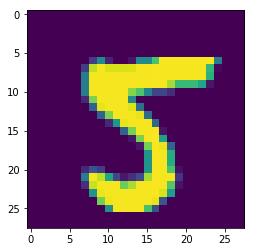

In [86]:
ind_test = random.randint(0, len(test_dataset)-1)
img, true = test_dataset[ind_test]
preds = model(img.unsqueeze(0).to(device))
pred = torch.argmax(preds).item()
plt.imshow(img.squeeze(0))
print('True: {}, Predicted: {}'.format(true, pred))